# Extract emebddings, PCA

May need to restart kernel for each dataset if worker error

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import pandas as pd 

# import my_custom_dataset_eval from 
import sys
sys.path.append('/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/evaluation/')
from my_custom_dataset_eval import CTDataset_test

In [9]:
starting_weights = "/home/ben/reef-audio-representation-learning/scratch/baseline/checkpoint-5100.pth.tar"

cfg = {'starting_weights': starting_weights, 'finetune': False,
       'data_path': '/mnt/ssd-cluster/ben/data/full_dataset/', 
       'json_path': '/home/ben/reef-audio-representation-learning/data/dataset.json',
       'test_dataset': 'test_kenya',#######################
       'num_classes': 2, #####################
       'num_workers':4} 

# Load model

In [10]:
# Load model

# Your model definition
class SimClrPytorchResNet50(nn.Module):
    def __init__(self, num_classes):
        super(SimClrPytorchResNet50, self).__init__()
        self.convnet = models.resnet50(weights=None)
        last_layer = self.convnet.fc
        in_features = last_layer.in_features
        self.convnet.fc = nn.Identity()
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        '''
            Forward pass. Here, we define how to apply our model. It's basically
            applying our modified ResNet-18 on the input tensor ("x") and then
            apply the final classifier layer on the ResNet-18 output to get our
            num_classes prediction.
        '''
        # x.size(): [B x 3 x W x H]
        features = self.convnet(x)    # features.size(): [B x 512 x W x H]
        prediction = self.classifier(features)  # prediction.size(): [B x num_classes]

        return prediction

# Your function to load pretrained weights
def load_pretrained_weights(cfg, model):
    custom_weights = cfg['starting_weights']
    state = torch.load(open(custom_weights, 'rb'), map_location='cpu')

    if 'state_dict' in state.keys():
        pretrained_dict = state['state_dict']
    else:
        print('oh no, state_dict not found in the model state keys')#pretrained_dict = state['model']

    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and k not in ['classifier.weight', 'classifier.bias']}
    log = model.load_state_dict(pretrained_dict, strict=False)
    assert log.missing_keys == ['classifier.weight', 'classifier.bias']
    return model

In [11]:
# Initialize your model
model_instance = SimClrPytorchResNet50(cfg['num_classes'])

### when feeling paranoid if wieghts are being loaded run this and compare to print out in next cell
# Print initial state dict
#print("Initial State Dict:")
#print(model_instance.state_dict())

In [12]:
# Load the pretrained weights
model_instance = load_pretrained_weights(cfg, model_instance)

### when feeling paranoid if wieghts are being loaded run this and compare to print out in aprevious cell

# # Print updated state dict
# print("Updated State Dict:")
# print(model_instance.state_dict())


# Dataloader

In [13]:
split = 'test_data'
transform = False
train_percent = 0.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
def get_dataloader(cfg, split, transform, train_percent, batch_size, shuffle, num_workers):
    
    dataset = CTDataset_test(cfg, split, transform, train_percent)

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle
    )

    return dataloader

sample_loader = get_dataloader(cfg, split, transform=False, train_percent = train_percent, batch_size=64, shuffle=False, num_workers=cfg['num_workers']) 


Does the below cell error? May need to restart kernel

In [15]:
def extract_multiple_embeddings(model, dataloader, device):
    model.eval()
    model.to(device) #move to gpu
    all_embeddings = []
    labels = []
    
    with torch.no_grad():
        for i, (audio, classes) in enumerate(dataloader):
            audio = audio.to(device) #move to gpu
            embeddings = model.convnet(audio)  # Get embeddings from the convnet
            all_embeddings.extend(embeddings.cpu().numpy())
            labels.extend(classes.cpu().numpy())
            
    return all_embeddings, labels

embeddings, labels = extract_multiple_embeddings(model_instance, sample_loader, device)

# Save the embeddings

In [16]:
import pandas as pd

# Assuming embeddings is your list of lists, each of 2048 features
# And labels is your list of labels

# Create a DataFrame
df = pd.DataFrame(embeddings, columns=[f'Feature_{i+1}' for i in range(2048)])

# Insert labels as the first column
df.insert(0, 'Label', labels)

# Save the DataFrame to CSV
df.to_csv('raw_embeddings/' + 'ReefCLR-' + cfg['test_dataset'][5:] + '-embeddings.csv', index=False)
df

,Label,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_2039,Feature_2040,Feature_2041,Feature_2042,Feature_2043,Feature_2044,Feature_2045,Feature_2046,Feature_2047,Feature_2048
0,1,0.919028,0.506934,0.435215,0.842612,0.390855,0.867625,0.704748,0.908792,1.011092,...,0.562921,0.542773,0.483578,0.631532,0.393116,0.530373,0.723051,0.580992,0.831317,0.568946
1,1,0.905521,0.424784,0.459844,0.766640,0.486458,0.858432,0.546274,1.176073,0.985820,...,0.635251,0.660854,0.464857,0.543516,0.411127,0.547460,0.654553,0.638909,1.050415,0.629480
2,0,0.917688,0.513418,0.442137,0.852096,0.384112,0.867285,0.686680,0.904982,1.006801,...,0.559864,0.542982,0.487606,0.628447,0.389822,0.533369,0.719379,0.577960,0.825859,0.575659
3,0,0.917862,0.512711,0.441923,0.852616,0.384108,0.867754,0.686703,0.904578,1.006853,...,0.560208,0.542105,0.486992,0.628390,0.389587,0.532686,0.719502,0.578081,0.825646,0.576382
4,0,0.921435,0.513003,0.440352,0.854395,0.383027,0.865497,0.684805,0.904298,1.007651,...,0.558675,0.547358,0.488635,0.625724,0.389663,0.530150,0.716523,0.576859,0.826569,0.575228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,1,0.918963,0.505533,0.439404,0.848247,0.389722,0.868852,0.683605,0.901832,1.001823,...,0.557642,0.541281,0.490158,0.625530,0.389466,0.536545,0.718873,0.577261,0.834662,0.571432
817,0,0.917636,0.512897,0.442011,0.852451,0.384122,0.867140,0.686455,0.904437,1.006422,...,0.559568,0.542606,0.487490,0.628551,0.389823,0.533656,0.719560,0.577747,0.826011,0.575708
818,1,0.916397,0.512910,0.442409,0.852778,0.382848,0.867302,0.687244,0.903119,1.005656,...,0.559070,0.543216,0.486861,0.628637,0.389633,0.533097,0.719473,0.578277,0.824144,0.573427
819,0,0.917790,0.512771,0.441886,0.851714,0.384423,0.867582,0.688235,0.905479,1.007172,...,0.560379,0.542561,0.486440,0.628526,0.389958,0.533367,0.720222,0.577236,0.826501,0.576425


# PCA plot

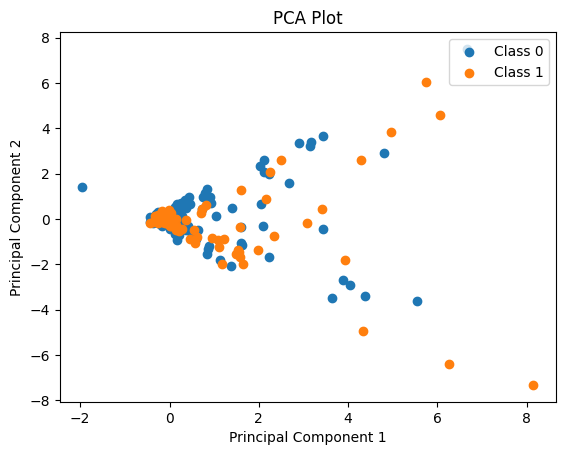

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings to a NumPy array for easier manipulation
embeddings = np.array(embeddings)

# Initialize PCA and the X vector for dimensionality reduction
pca = PCA(n_components=2)

# Fit and transform the embeddings to get new 2D representations
embeddings_pca = pca.fit_transform(embeddings)

# Create a scatter plot
classes = np.unique(labels)  # Extract unique labels to identify distinct classes
for class_label in classes:
    idx = np.where(np.array(labels) == class_label)  # Get index where class label is found
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1], label=f"Class {class_label}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="upper right")
plt.title("PCA Plot")
plt.show()